  0%|                                                                                  | 1/999 [00:02<39:27,  2.37s/it]C:\Users\micha\AppData\Local\Temp\ipykernel_6852\952435589.py:49: RuntimeWarning: invalid value encountered in add
  phi[:, :, ti + 1] = phi[:, :, ti] + (k1 + 2 * k2 + 2 * k3 + k4) / 6.0
C:\Users\micha\AppData\Local\Temp\ipykernel_6852\952435589.py:46: RuntimeWarning: invalid value encountered in add
  k2 = dt * wave_equation(phi[:, :, ti] + 0.5 * k1, np.linspace(0, R, Nr), theta)
100%|███████████████████████████████████████████████████████████████████████████████| 999/999 [00:03<00:00, 277.66it/s]


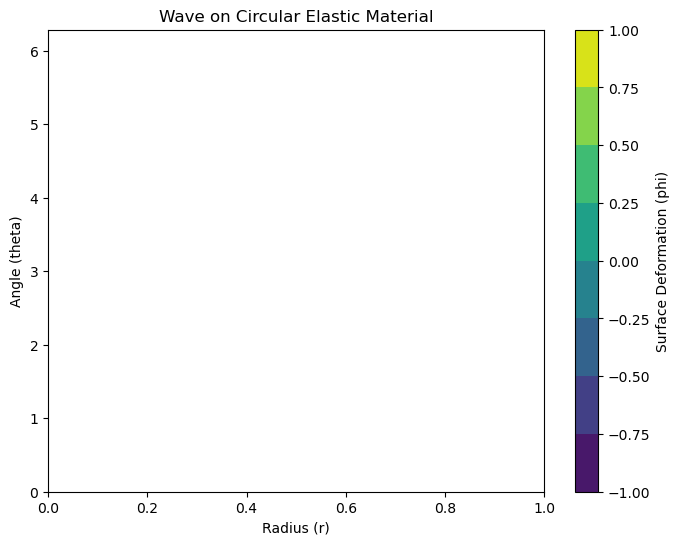

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import njit

# Parameters
R = 1.0  # Radius of the circular elastic material
A = 1.0  # Amplitude of the wave
omega = 1.0  # Angular frequency of the wave
c = 1.0  # Speed of the wave

# Spatial and temporal discretization
Nr = 100  # Number of radial grid points
Ntheta = 100  # Number of angular grid points
Nt = 1000  # Number of time steps
dr = R / Nr  # Radial grid spacing
dtheta = 2 * np.pi / Ntheta  # Angular grid spacing
dt = 0.01  # Time step size

# Initialize solution array
phi = np.zeros((Nr, Ntheta, Nt))

# Initial conditions
phi[:, :, 0] = 0.0

# Boundary conditions
theta = np.linspace(0, 2 * np.pi, Ntheta)
t = np.arange(Nt) * dt
for ti in range(Nt):
    phi[:, :, ti] = A * np.cos(omega * t[ti]) * np.cos(theta)

# Define the wave equation
@njit
def wave_equation(phi, r, theta):
    d2phi_dt2 = np.zeros_like(phi)
    for i in range(1, Nr - 1):
        for j in range(Ntheta):
            d2phi_dr2 = (1 / r[i]) * (phi[i + 1, j] - 2 * phi[i, j] + phi[i - 1, j]) / dr**2
            d2phi_dtheta2 = (1 / r[i]**2) * (phi[i, (j + 1) % Ntheta] - 2 * phi[i, j] + phi[i, (j - 1) % Ntheta]) / dtheta**2
            d2phi_dt2[i, j] = c**2 * (d2phi_dr2 + d2phi_dtheta2)
    return d2phi_dt2

# Perform time integration using fourth-order Runge-Kutta method
for ti in tqdm(range(Nt - 1)):
    k1 = dt * wave_equation(phi[:, :, ti], np.linspace(0, R, Nr), theta)
    k2 = dt * wave_equation(phi[:, :, ti] + 0.5 * k1, np.linspace(0, R, Nr), theta)
    k3 = dt * wave_equation(phi[:, :, ti] + 0.5 * k2, np.linspace(0, R, Nr), theta)
    k4 = dt * wave_equation(phi[:, :, ti] + k3, np.linspace(0, R, Nr), theta)
    phi[:, :, ti + 1] = phi[:, :, ti] + (k1 + 2 * k2 + 2 * k3 + k4) / 6.0

# Plot the solution at a specific time step
plt.figure(figsize=(8, 6))
plt.contourf(np.linspace(0, R, Nr), theta, phi[:, :, -1], cmap='viridis')
plt.colorbar(label='Surface Deformation (phi)')
plt.title('Wave on Circular Elastic Material')
plt.xlabel('Radius (r)')
plt.ylabel('Angle (theta)')
plt.show()


C:\Users\micha\AppData\Local\Temp\ipykernel_5480\834334923.py:48: RuntimeWarning: overflow encountered in exp
  phi_hat *= np.exp(wave_equation_fft(phi_hat, Freq_r_grid, Freq_theta_grid) * dt)
C:\Users\micha\AppData\Local\Temp\ipykernel_5480\834334923.py:48: RuntimeWarning: invalid value encountered in multiply
  phi_hat *= np.exp(wave_equation_fft(phi_hat, Freq_r_grid, Freq_theta_grid) * dt)
C:\Users\micha\AppData\Local\Temp\ipykernel_5480\834334923.py:43: RuntimeWarning: invalid value encountered in multiply
  return -c**2 * (k_r_squared + k_theta_squared) * phi_hat


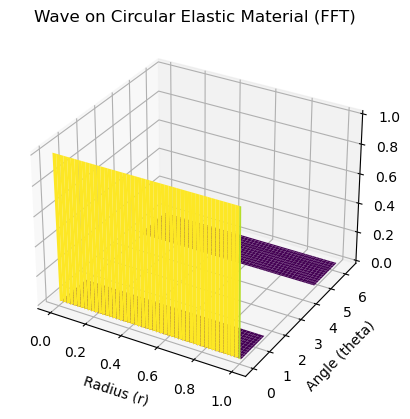

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq

# Parameters
R = 1.0  # Radius of the circular elastic material
A = 1.0  # Amplitude of the wave
omega = 1.0  # Angular frequency of the wave
c = 1.0  # Speed of the wave

# Spatial and temporal discretization
Nr = 100  # Number of radial grid points
Ntheta = 100  # Number of angular grid points
Nt = 1000  # Number of time steps
dr = R / Nr  # Radial grid spacing
dtheta = 2 * np.pi / Ntheta  # Angular grid spacing
dt = 0.01  # Time step size

# Create radial and angular grids
r = np.linspace(0, R, Nr)
theta = np.linspace(0, 2 * np.pi, Ntheta)
R_grid, Theta_grid = np.meshgrid(r, theta, indexing='ij')

# Frequency grids for FFT
freq_r = fftfreq(Nr, dr)
freq_theta = fftfreq(Ntheta, dtheta)
Freq_r_grid, Freq_theta_grid = np.meshgrid(freq_r, freq_theta, indexing='ij')

# Initialize solution array
phi = np.zeros((Nr, Ntheta, Nt), dtype=complex)

# Initial conditions
phi[:, :, 0] = 0.0

# Boundary conditions
for i in range(Nt):
    phi[:, :, i] = A * np.cos(omega * i * dt) * np.cos(Theta_grid)

# Define the wave equation in frequency domain
def wave_equation_fft(phi_hat, Freq_r, Freq_theta):
    k_r_squared = (2 * np.pi * Freq_r)**2
    k_theta_squared = (2 * np.pi * Freq_theta)**2
    return -c**2 * (k_r_squared + k_theta_squared) * phi_hat

# Perform time integration using FFT
for ti in range(Nt - 1):
    phi_hat = fft(phi[:, :, ti], axis=0)
    phi_hat *= np.exp(wave_equation_fft(phi_hat, Freq_r_grid, Freq_theta_grid) * dt)
    phi[:, :, ti + 1] = np.real(ifft(phi_hat, axis=0))

# Plot the solution at a specific time step
# plt.figure(figsize=(8, 6))
# plt.contourf(R_grid, Theta_grid, np.real(phi[:, :, -1]), cmap='viridis')
# plt.colorbar(label='Surface Deformation (phi)')

fig, ax = plt.subplots(subplot_kw=dict(projection="3d"))
ax.plot_surface(R_grid, Theta_grid, np.real(phi[:, :, 700]), cmap="viridis", edgecolor="none")
plt.title('Wave on Circular Elastic Material (FFT)')
plt.xlabel('Radius (r)')
plt.ylabel('Angle (theta)')
plt.show()


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]C:\Users\micha\AppData\Local\Temp\ipykernel_3460\1760427089.py:35: RuntimeWarning: overflow encountered in scalar divide
  d2phi_dtheta2 = (phi_curr[i, (j + 1) % num_theta] - 2 * phi_curr[i, j] + phi_curr[i, (j - 1) % num_theta]) / (dtheta ** 2)
  0%|▏                                                                                | 3/1000 [00:00<00:43, 23.09it/s]C:\Users\micha\AppData\Local\Temp\ipykernel_3460\1760427089.py:34: RuntimeWarning: overflow encountered in scalar divide
  d2phi_dr2 = (phi_curr[i + 1, j] - 2 * phi_curr[i, j] + phi_curr[i - 1, j]) / (dr ** 2)
C:\Users\micha\AppData\Local\Temp\ipykernel_3460\1760427089.py:34: RuntimeWarning: invalid value encountered in scalar add
  d2phi_dr2 = (phi_curr[i + 1, j] - 2 * phi_curr[i, j] + phi_curr[i - 1, j]) / (dr ** 2)
C:\Users\micha\AppData\Local\Temp\ipykernel_3460\1760427089.py:35: RuntimeWarning: invalid val

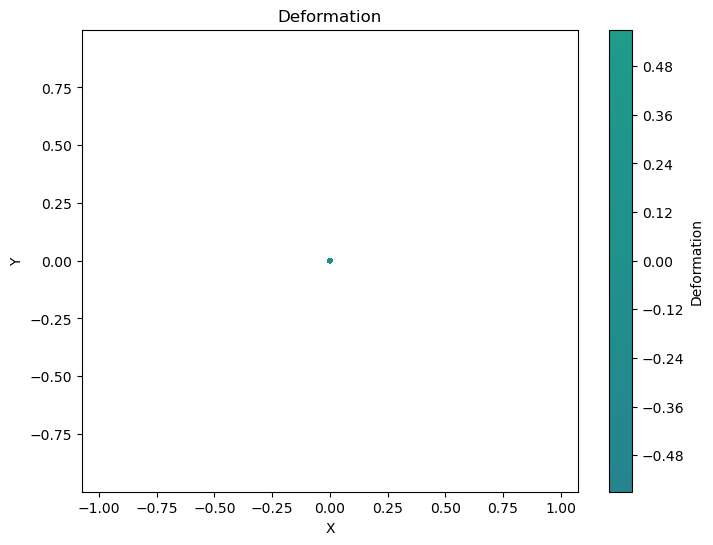

In [1]:
import numpy as np
from scipy.special import jn  # Bessel function of the first kind
import matplotlib.pyplot as plt
from tqdm import tqdm

def fwd_euler(R, A, omega, c, tmax, num_timesteps, num_r, num_theta):
    # Parameters


    
    dt = tmax/num_timesteps  # Time step size
    dr = R / (num_r - 1)  # Radial step size
    dtheta = 2 * np.pi / num_theta  # Angular step size

    # Initialize arrays for phi at different time steps
    phi_curr = np.zeros((num_r, num_theta))  # Current time step
    phi_prev = np.zeros((num_r, num_theta))  # Previous time step

    # Initial condition: phi(r, theta, t=0) = 0
    phi_curr[:, :] = 0

    # Boundary condition: phi(r=0, theta, t) is finite
    phi_curr[0, :] = 0
    phi_tot = []
    phi_tot.append(phi_curr)

    # Time-stepping loop
    for n in tqdm(range(1, num_timesteps + 1)):

        # Update phi using forward Euler method
        for i in range(2, num_r - 1):
            for j in range(num_theta):
                # Spatial derivatives
                d2phi_dr2 = (phi_curr[i + 1, j] - 2 * phi_curr[i, j] + phi_curr[i - 1, j]) / (dr ** 2)
                d2phi_dtheta2 = (phi_curr[i, (j + 1) % num_theta] - 2 * phi_curr[i, j] + phi_curr[i, (j - 1) % num_theta]) / (dtheta ** 2)

                # Temporal derivative
                d2phi_dt2 = c ** 2 * (d2phi_dr2 + 1 / (dr*i)**2 * d2phi_dtheta2)

                # Update phi using forward Euler method
                phi_next = 2 * phi_curr[i, j] - phi_prev[i, j] + dt ** 2 * d2phi_dt2
                # Update phi for the next time step
                phi_prev[i, j] = phi_curr[i, j]
                phi_curr[i, j] = phi_next
        

        # Boundary condition: phi(r=R, theta, t) = A * cos(omega * t) * cos(theta)
        phi_curr[-1, :] = A * np.cos(omega * n * dt) * np.cos(np.linspace(0, 2 * np.pi, num_theta))
        phi_tot.append(phi_curr)
    # Plot the final state of phi at the last time step
    R_grid, Theta_grid = np.meshgrid(np.linspace(0, R, num_r), np.linspace(0, 2 * np.pi, num_theta))
    X = R_grid * np.cos(Theta_grid)
    Y = R_grid * np.sin(Theta_grid)

    plt.figure(figsize=(8, 6))
    contour = plt.contourf(X, Y, phi_curr.T, levels=100, cmap='viridis')
    colorbar = plt.colorbar(contour)
    colorbar.set_label('Deformation')
    contour.set_clim(-6, 6)  # Set colorbar limits to -6 to 6
    plt.title('Deformation')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.axis('equal')
    plt.show()
    
# Example usage
R = 1.0  # Radius of the circular elastic material
A = 1.0  # Amplitude of the wave
omega = 1.0  # Angular frequency of the wave
c = 1.0  # Speed of the wave
tmax = 1000.0  # Maximum time
num_timesteps = 1000  # Number of time steps
num_r = 100  # Number of radial grid points
num_theta = 100  # Number of angular grid points

fwd_euler(R, A, omega, c, tmax, num_timesteps, num_r, num_theta)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1400.09it/s]


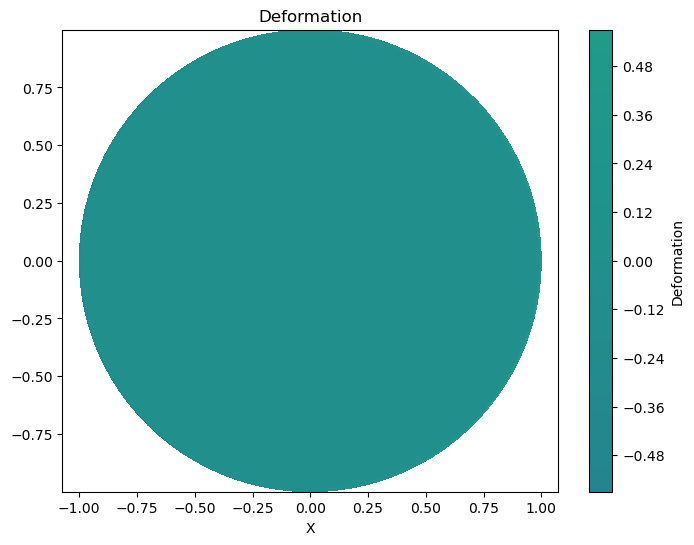

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq
from tqdm import tqdm


def fft_solver(R, A, omega, c, tmax, num_timesteps, num_r, num_theta):

    # Parameters
    dt = tmax / num_timesteps  # Time step size
    dr = R / (num_r - 1)  # Radial step size
    dtheta = 2 * np.pi / num_theta  # Angular step size

    # Create radial and angular grids
    r = np.linspace(0, R, num_r)
    theta = np.linspace(0, 2 * np.pi, num_theta)
    R_grid, Theta_grid = np.meshgrid(r, theta, indexing="ij")

    # Initialize arrays for phi at different time steps
    phi_curr = np.zeros((num_r, num_theta))  # Current time step
    phi_prev = np.zeros((num_r, num_theta))  # Previous time step

    # Initial condition: phi(r, theta, t=0) = 0
    phi_curr[:, :] = 0

    # Boundary condition: phi(r=0, theta, t) is finite
    phi_curr[0, :] = 0
    phi_tot = []
    phi_tot.append(phi_curr)

    # Initialize arrays to store the Fourier-transformed solutions
    phi_hat_curr = fft(phi_curr, axis=0)
    phi_hat_prev = fft(phi_prev, axis=0)

    # Time-stepping loop
    for n in tqdm(range(1, num_timesteps + 1)):

        # Calculate frequencies
        freq_r = fftfreq(num_r, dr)
        freq_theta = fftfreq(num_theta, dtheta)

        # Calculate Laplacian in frequency domain
        k_r_squared = (2 * np.pi * freq_r) ** 2
        k_theta_squared = (2 * np.pi * freq_theta) ** 2
        laplacian = -(c**2) * (k_r_squared[:, np.newaxis] + k_theta_squared)

        # Update phi in frequency domain using Forward Euler
        phi_hat_next = (
            2 * phi_hat_curr - phi_hat_prev + dt**2 * laplacian * phi_hat_curr
        )

        # Transform back to spatial domain
        phi_next = np.real(ifft(phi_hat_next, axis=0))

        # Update phi for the next time step
        phi_prev[:] = phi_curr[:]
        phi_curr[:] = phi_next[:]

        # Boundary condition: phi(r=R, theta, t) = A * cos(omega * t) * cos(theta)
        phi_curr[-1, :] = (
            A * np.cos(omega * n * dt) * np.cos(np.linspace(0, 2 * np.pi, num_theta))
        )
        phi_tot.append(phi_curr)

    # Plot the final state of phi at the last time step
    R_grid, Theta_grid = np.meshgrid(
        np.linspace(0, R, num_r), np.linspace(0, 2 * np.pi, num_theta)
    )
    X = R_grid * np.cos(Theta_grid)
    Y = R_grid * np.sin(Theta_grid)

    plt.figure(figsize=(8, 6))
    contour = plt.contourf(X, Y, phi_curr.T, levels=100, cmap="viridis")
    colorbar = plt.colorbar(contour)
    colorbar.set_label("Deformation")
    contour.set_clim(-6, 6)  # Set colorbar limits to -6 to 6
    plt.title("Deformation")
    plt.xlabel("X")
    plt.axis("equal")
    plt.show()

# Example usage
R = 1.0  # Radius of the circular elastic material
A = 1.0  # Amplitude of the wave
omega = 1.0  # Angular frequency of the wave
c = 1.0  # Speed of the wave
tmax = 1000.0  # Maximum time
num_timesteps = 1000  # Number of time steps
num_r = 100  # Number of radial grid points
num_theta = 100  # Number of angular grid points

fft_solver(R, A, omega, c, tmax, num_timesteps, num_r, num_theta)


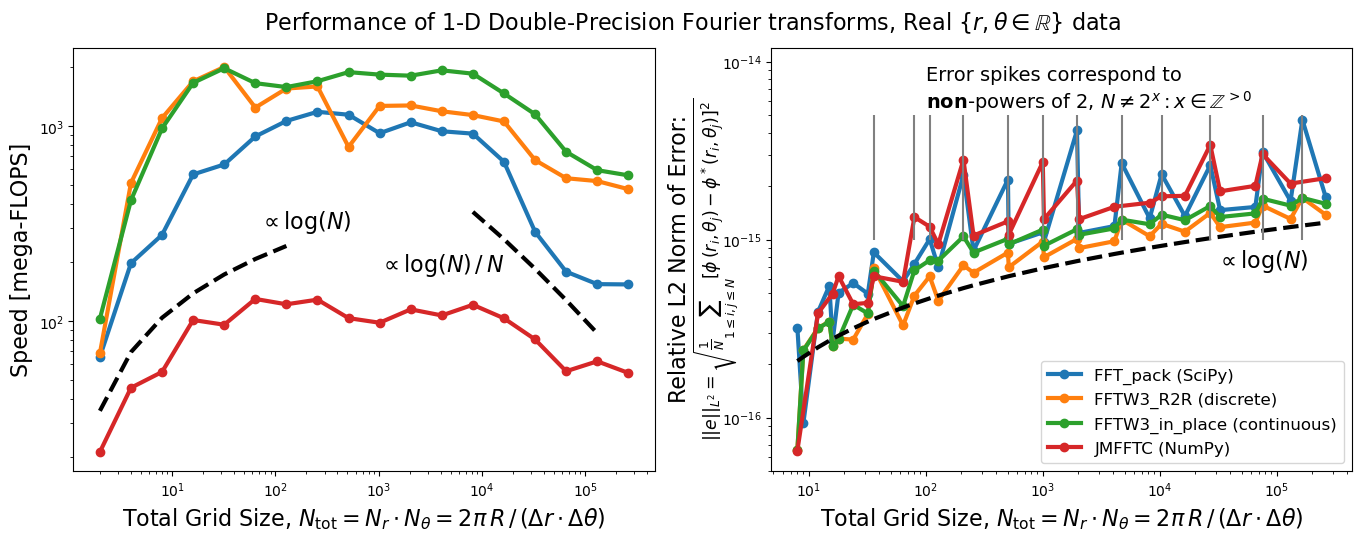

In [153]:
#Import libraries: Matplotlib and SciPy I/O.
from numpy import *
import matplotlib.pyplot as plt
import scipy.io 

from matplotlib.pyplot import *
from mpl_toolkits.mplot3d import Axes3D

from pylab import rcParams
import matplotlib as mpl

f      = open('./Speed data.csv', 'r')
data = genfromtxt(f, delimiter=',')
f.close()

N_speed = data[:,0]
FFT_pack_speed = data[:,1]
FFTW3_R2R_speed = data[:,3]
FFTW3_in_place_speed = data[:,5]
JMFFTC_speed = data[:,7]

f      = open('./Error data.csv', 'r')
data = genfromtxt(f, delimiter=',')
f.close()

N_error = data[:,0]
FFT_pack_error = data[:,1]
FFTW3_R2R_error = data[:,3]
FFTW3_in_place_error = data[:,5]
N_JMFFTC_error = data[:,6]
JMFFTC_error = data[:,7]


fig,(ax1,ax2) = subplots(nrows=1, ncols=2, figsize=(16.5, 5.5))
ax1.plot(N_speed, FFT_pack_speed, '-o', lw=3, label='FFT_pack (SciPy)')
ax1.plot(N_speed, FFTW3_R2R_speed, '-o', lw=3, label='FFTW3_R2R (discrete)')
ax1.plot(N_speed, FFTW3_in_place_speed, '-o', lw=3, label='FFTW3_in_place (continuous)')
ax1.plot(N_speed, JMFFTC_speed, '-o', lw=3, label='JMFFTC (NumPy)')

ax1.plot(N_speed[0:8], 50 * np.log(N_speed[0:8]), 'k--', lw=3)
ax1.text(70, 300, r'$\propto \log(N)$', fontsize=16)

ax1.plot(N_speed[13:18], 50 * (N_speed[13:18])**(-1) * np.log(N_speed[13:18])**5, 'k--', lw=3)
ax1.text(1000, 180, r'$\propto \log(N) \, / \, N $', fontsize=16)

ax2.plot(N_error, FFT_pack_error, '-o', lw=3, label='FFT_pack (SciPy)')
ax2.plot(N_error, FFTW3_R2R_error, '-o', lw=3, label='FFTW3_R2R (discrete)')
ax2.plot(N_error, FFTW3_in_place_error, '-o', lw=3, label='FFTW3_in_place (continuous)')
ax2.plot(N_JMFFTC_error, JMFFTC_error, '-o', lw=3, label='JMFFTC (NumPy)')

ax2.plot(N_error, 10**(-16) * np.log(N_error), 'k--', lw=3)
ax2.text(3 * 10**4, 7 * 10**(-16), r'$\propto \log(N)$', fontsize=16)
ax2.text(100, 5.5 * 10**(-15), r'Error spikes correspond to' '\n' r'$\mathbf{non}$-powers of 2, $N \neq 2^x : x \in \mathbb{Z}^{>0}$', fontsize=14)

ax1.set_xlabel(r'Total Grid Size, $N_\mathrm{tot} = N_r \cdot N_{\theta} = 2 \pi \, R \, / \, (\Delta r \cdot \Delta \theta)$', fontsize=16)
ax1.set_ylabel('Speed [mega-FLOPS]', color='k', fontsize=16)

ax2.set_xlabel(r'Total Grid Size, $N_\mathrm{tot} = N_r \cdot N_{\theta} = 2 \pi \, R \, / \, (\Delta r \cdot \Delta \theta)$', fontsize=16)
#ax2.set_ylabel('Relative L2 Norm of Error:', color='k', fontsize=14)
ax2.text(0.63, 1.3 * 10**(-16), 'Relative L2 Norm of Error:', color='k', fontsize=16, rotation=90)
ax2.text(1, 10**(-16), r'$||e||_{L^2} = \sqrt{\frac{1}{N} \sum_{1 \leq i,j \leq N} [\phi \, (r_i, \theta_j) - \phi^*(r_i, \theta_j)]^2}$', color='k', fontsize=12.5, rotation=90)

ax1.set_xscale('log')
ax1.set_yscale('log')

ax2.vlines(36, 10**(-15), 5 * 10**(-15), colors='gray', linestyles='solid')
ax2.vlines(80, 10**(-15), 5 * 10**(-15), colors='gray', linestyles='solid')
ax2.vlines(108, 10**(-15), 5 * 10**(-15), colors='gray', linestyles='solid')
ax2.vlines(210, 10**(-15), 5 * 10**(-15), colors='gray', linestyles='solid')
ax2.vlines(504, 10**(-15), 5 * 10**(-15), colors='gray', linestyles='solid')
ax2.vlines(1000, 10**(-15), 5 * 10**(-15), colors='gray', linestyles='solid')
ax2.vlines(1960, 10**(-15), 5 * 10**(-15), colors='gray', linestyles='solid')
ax2.vlines(4725, 10**(-15), 5 * 10**(-15), colors='gray', linestyles='solid')
ax2.vlines(10368, 10**(-15), 5 * 10**(-15), colors='gray', linestyles='solid')
ax2.vlines(27000, 10**(-15), 5 * 10**(-15), colors='gray', linestyles='solid')
ax2.vlines(75600, 10**(-15), 5 * 10**(-15), colors='gray', linestyles='solid')
ax2.vlines(165375, 10**(-15), 5 * 10**(-15), colors='gray', linestyles='solid')

plt.suptitle(r'Performance of 1-D Double-Precision Fourier transforms, Real $\{r, \theta \in \mathbb{R}\}$ data', fontsize=16, y=0.95)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_ylim(5 * 10**(-17), 1.2 * 10**(-14))
plt.legend(loc='lower right', fontsize=12)
plt.show()
